# Aggregate by weights and by counts


We assign weights to the examples whose values are inversely proportional to the number of measures
reported by the corresponding cruise ID. If the cruise reports more measures, the measures are assigned
smaller weights, and vice versa.

In the following plots, **the first column** is the cummulative curve aggreagated **over the weights**,
and **the second column** is the one that aggregated **over the counts** (i.e. ignore the weights)

In [4]:
import os
import pickle
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.font_manager import FontProperties
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve

def get_precision_recall(labels, scores):
    num_pos = np.sum(labels == 1)
    num_neg = labels.shape[0] - num_pos
    precision, recall, thr = precision_recall_curve(labels, scores, pos_label=1)
    # auprc = auc(recall, precision)
    recall_neg = (1.0 - precision) * (recall * num_pos / precision) / num_neg
    return (precision, recall, thr, recall_neg)


def plot_prc(precision, recall, thr, recall_neg, get_label, ax, legend):
    ax.plot(recall, precision)
    ax.set_xlim(0.0, 1.0)
    # ax.set_ylim(0.0, 1.0)

    scatter_x, scatter_y = [], []
    last_recall = 1.0
    for x, y, threshold, pn in zip(recall, precision, thr, recall_neg):
        if last_recall - x >= 0.1 or last_recall - x >= 0.05 and x >= 0.9:
            ax.annotate(get_label(threshold),
                         (x,y),
                         textcoords="offset points",
                         xytext=(0,10),
                         ha='center')
            ax.annotate("{:.2f}".format(pn),
                         (x,y),
                         textcoords="offset points",
                         xytext=(0,-18),
                         ha='center')
            scatter_x.append(x)
            scatter_y.append(y)
            last_recall = x

    ax.scatter(scatter_x, scatter_y)

    font = FontProperties()
    font.set_family("monospace")
    font.set_size(14)
    ax.text(0.03, 0.13, legend,
            transform=ax.transAxes, fontproperties=font,
            verticalalignment='top', bbox=dict(alpha=0.3));
    ax.minorticks_on()
    ax.grid(which='major', linestyle='-', linewidth='1.0',)
    ax.grid(which='minor', linestyle=':', linewidth='1.0',);


def plot_edit_rescue(data, label):
    _, labels, scores, _ = data
    edit_rate = (len(labels) - np.sum(labels)) / len(labels) * 100.0

    fig, ax = plt.subplots(1, 2, figsize=(20, 6))
    precision, recall, thr, recall_neg = get_precision_recall(labels, scores)
    plot_prc(precision, recall, thr, recall_neg, lambda v: ">{:.2e}".format(v), ax[0],
            '>9.99e-01  Threshold\n 0.02  BL(Ɵ)/B')
    ax[0].set_title("(Rescue?) Export good examples in " + label + ", edit rate: {:.2f}%".format(edit_rate))
    ax[0].set_xlabel("GL(Ɵ)/G")
    ax[0].set_ylabel("GL(Ɵ)/L(Ɵ)")

    precision, recall, thr, recall_neg = get_precision_recall(1.0 - labels, 1.0 - scores)
    plot_prc(precision, recall, thr, recall_neg, lambda v: "<{:.2e}".format(1.0 - v), ax[1],
            '<1.72e-1  Threshold Ɵ\n 0.02  GS(Ɵ)/G')
    ax[1].set_yscale("log")
    ax[1].set_xlabel("BS(Ɵ)/B")
    ax[1].set_ylabel("BS(Ɵ)/S(Ɵ)")
    ax[1].set_title("(Edit?) Export bad examples in " + label + ", edit rate: {:.2f}%".format(edit_rate))

    fig.tight_layout();

# Precision-Recall

In [2]:
base_dir = "../../chulk-logs/runtime_scores"
_style = ['b', 'r']
sources = ['AGSO', 'JAMSTEC', 'JAMSTEC2', 'NGA', 'NGA2', 'NGDC', 'NOAA_geodas', 'SIO', 'US_multi']

## Explnation of recall-precision graph

The following graphs represent the performance of using different thresholds on the predicted scores on the precision and recall.

The meaning of precision and recall in different in editing and in rescuing.

### Basic quantities


Label: 0 is corrupt, 1 is good

We expect the bad examples receive the scores of small values, and the good examples receive the scores of
large values. Furthermore, we define following basic quantities.

* $BS(\theta)$: the # of bad examples that receive small scores when the threshold is $<\theta$.
* $GS(\theta)$: the # of good examples that receive large scores when the threshold is $<\theta$.
* $BL(\theta)$: the # of bad examples that receive large scores when the threshold is $>\theta$.
* $GL(\theta)$: the # of good examples that receive large scores when the threshold is $>\theta$.

In addition,

* $B$: the # of bad examples
* $G$: the # of good examples
* $S(\theta)$: the # of examples that receive a score smaller than $\theta$
* $G(\theta)$: the # of examples that receive a score larger than $\theta$


### Editing

In editing, we want to export the good examples. In this case, the X-axis is $GL(\theta)/G$ (recall),
and the Y-axis is $GL(\theta)/L(\theta)$ (precision).


### Rescuing

In rescue, we want to export the bad examples (then assume all that not exported are good).
In this case, the X-axis is $BS(\theta)/B$ (recall),
and the Y-axis is $BS(\theta)/S(\theta)$ (precision).

AGSO, JAMSTEC, JAMSTEC2, NGA, NGA2, NGDC, NOAA_geodas, SIO, US_multi, 

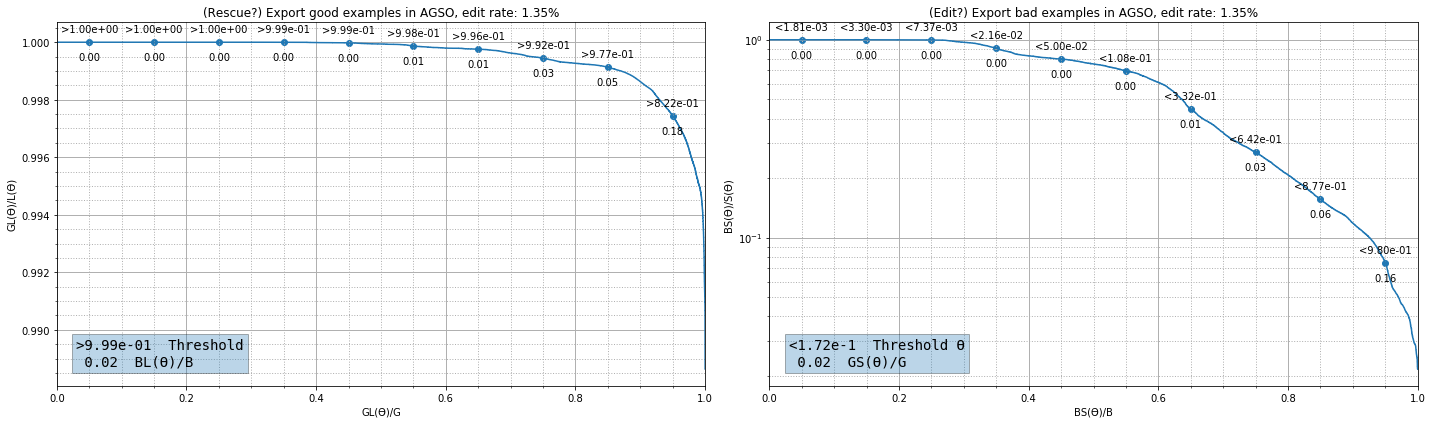

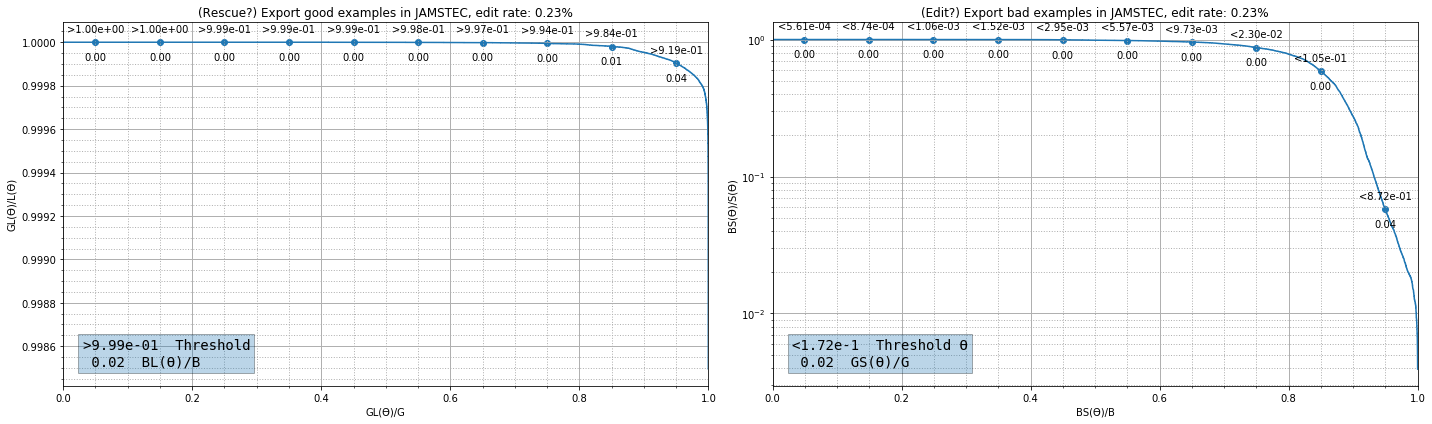

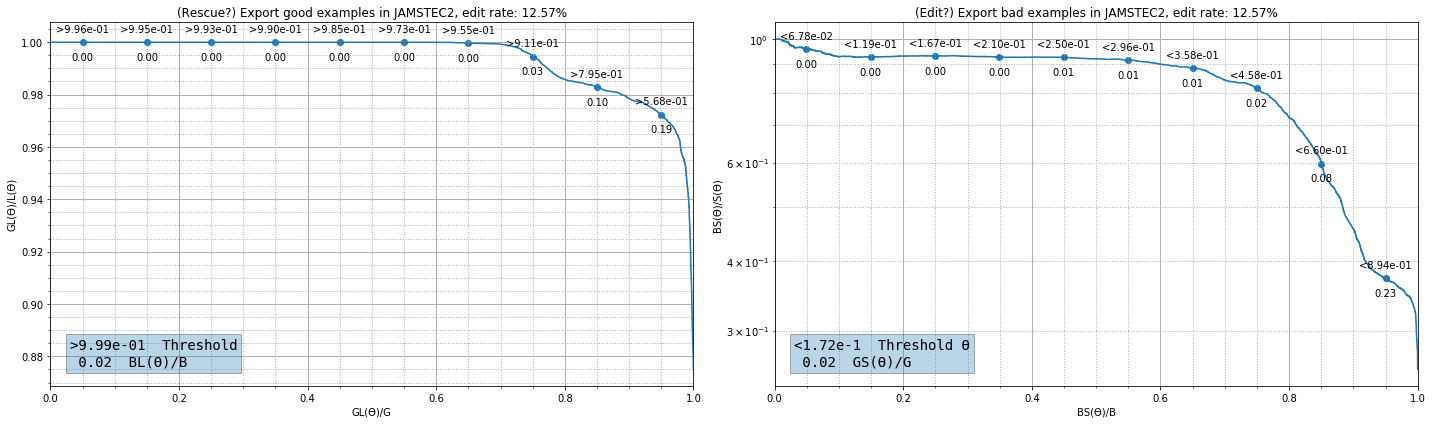

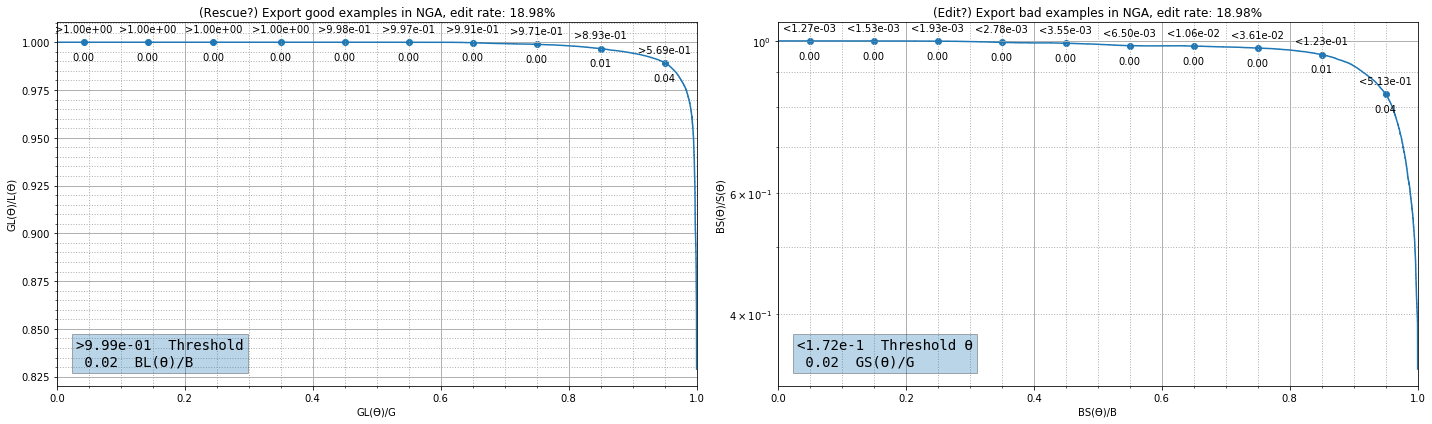

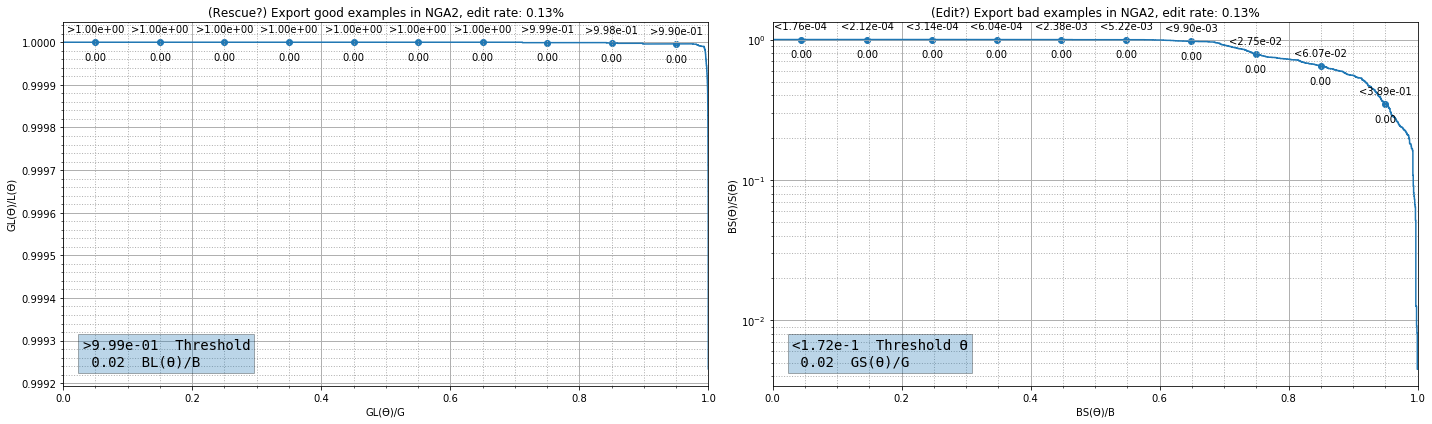

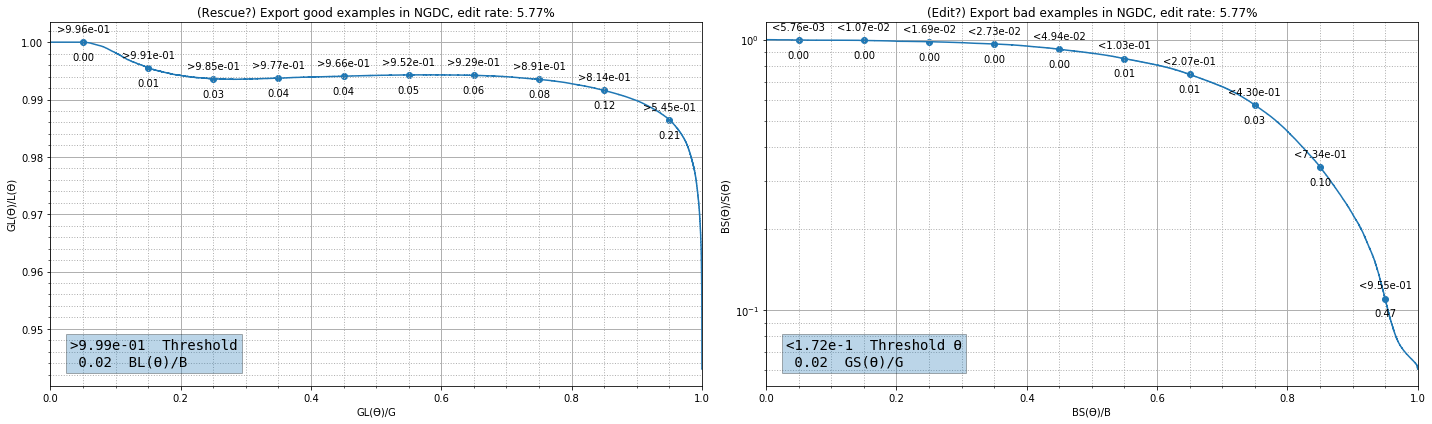

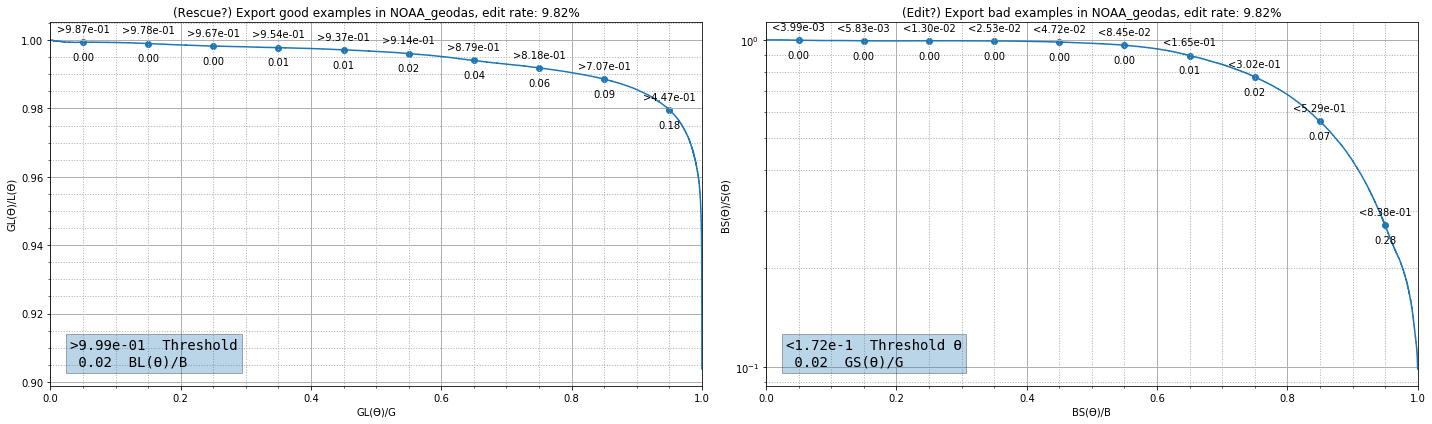

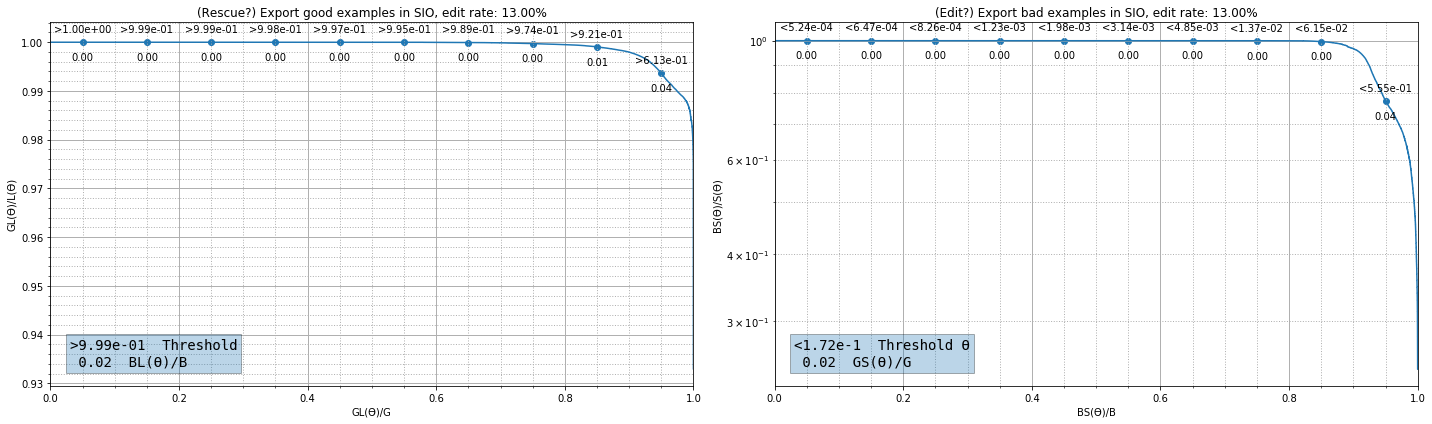

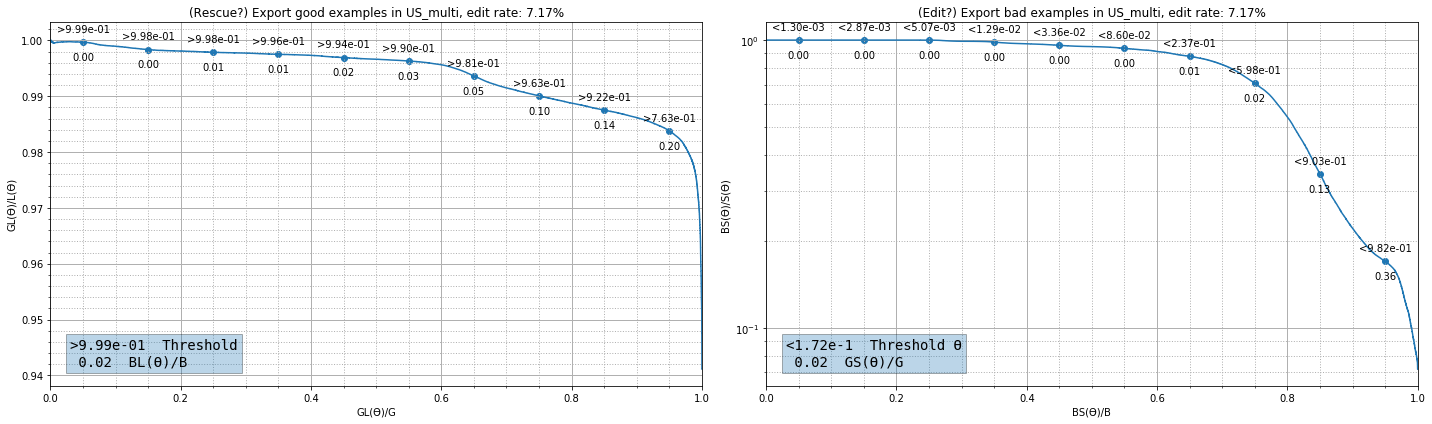

In [5]:
for source in sources:
    print(source, end=", ")
    path = os.path.join(base_dir, "model_{0:}_test_{0:}_scores.pkl".format(source))
    with open(path, 'rb') as f:
        data = pickle.load(f)
    plot_edit_rescue(data, source)

AGSO, JAMSTEC, JAMSTEC2, NGA, NGA2, 

/Users/igpp-jalafate/dev/virtualenv/py3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


NGDC, NOAA_geodas, SIO, US_multi, 

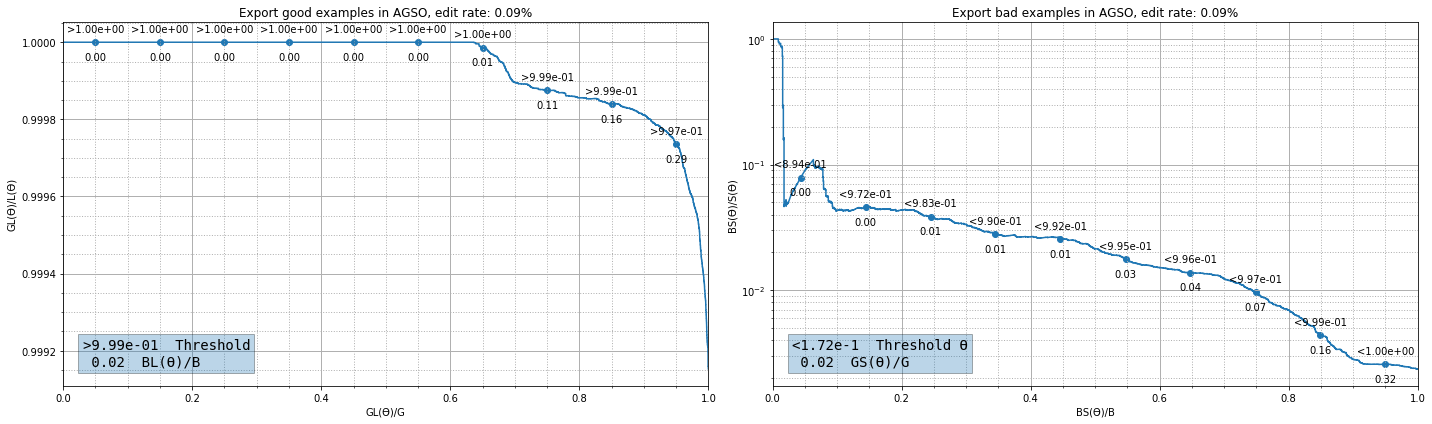

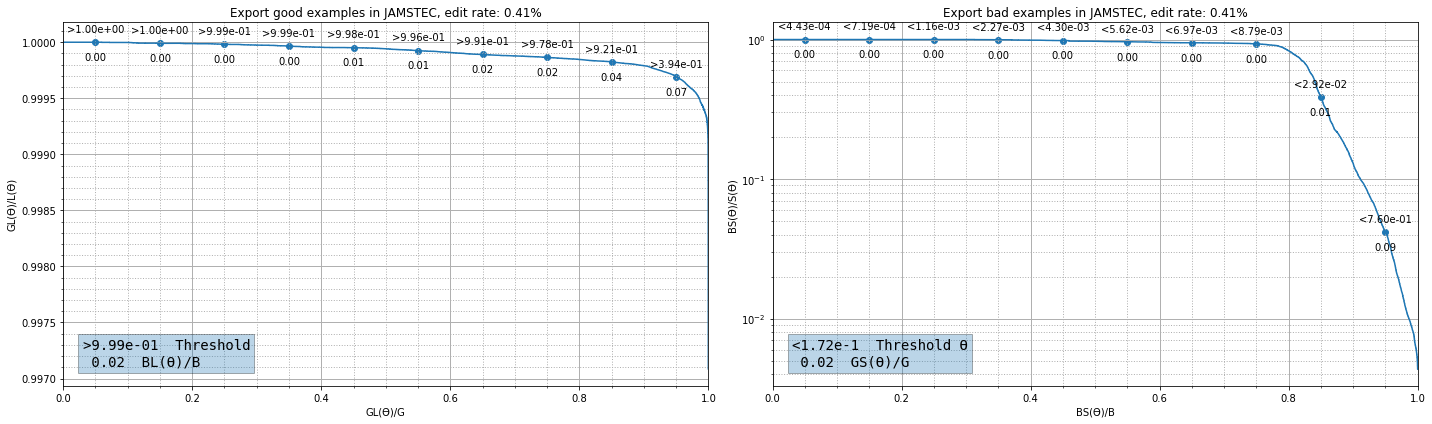

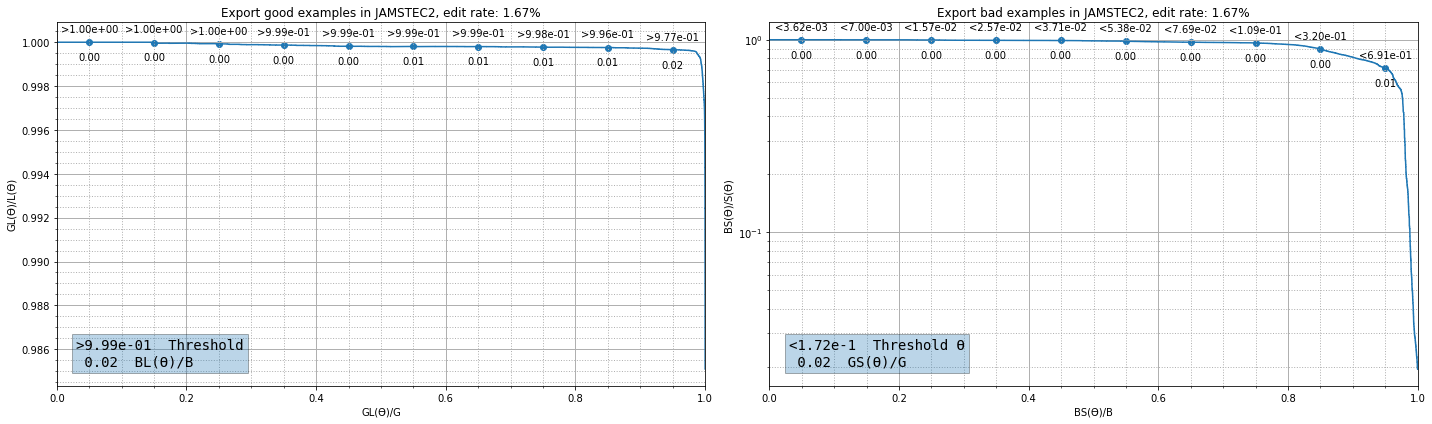

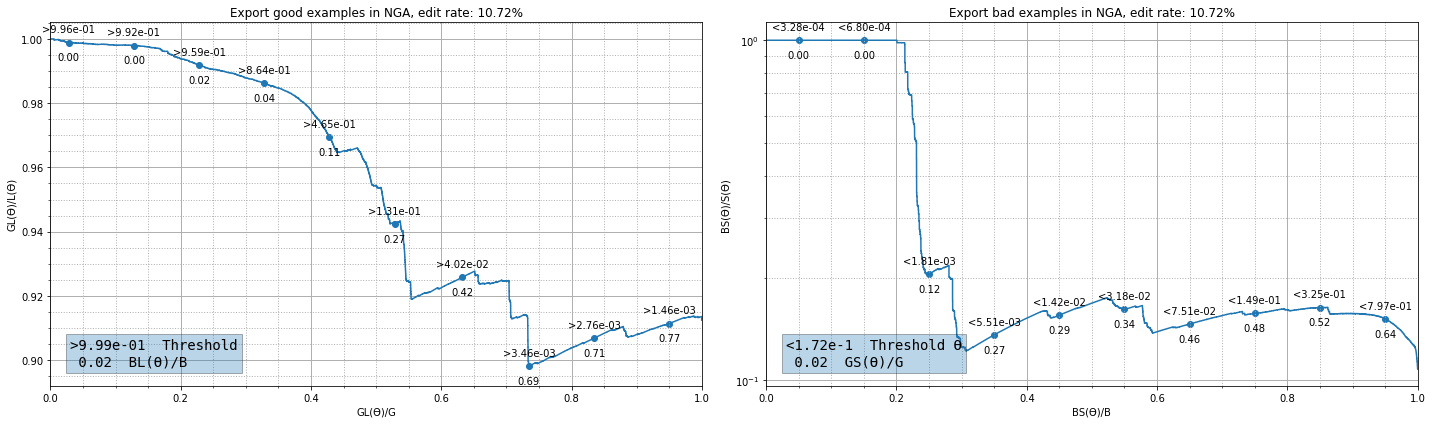

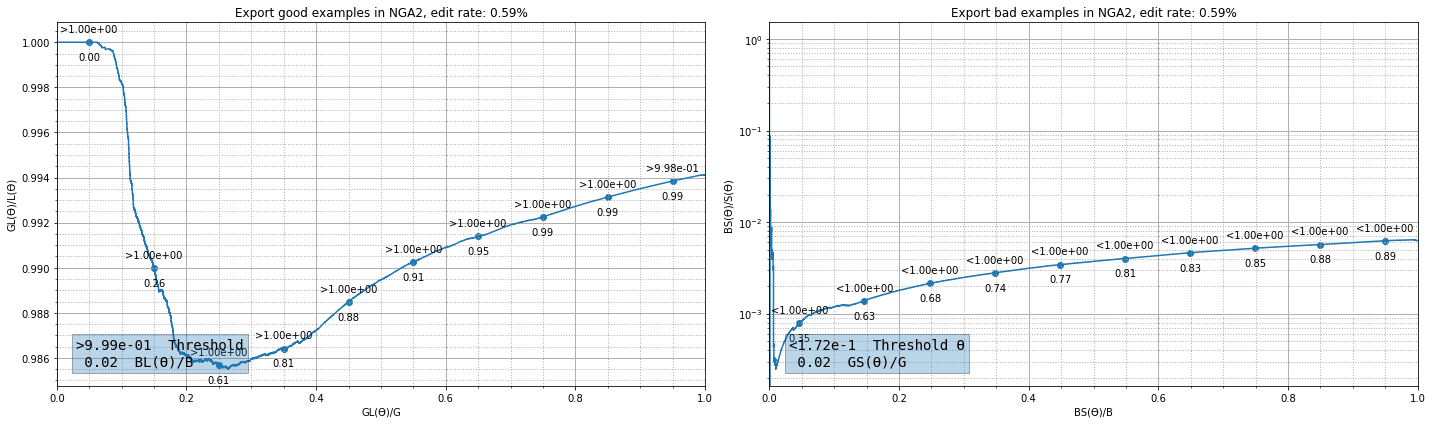

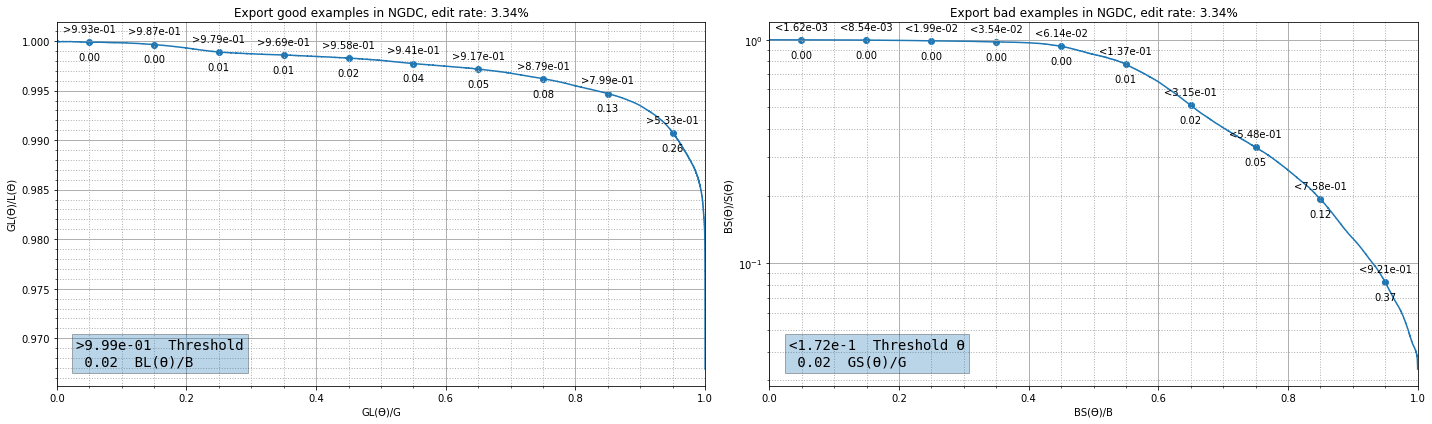

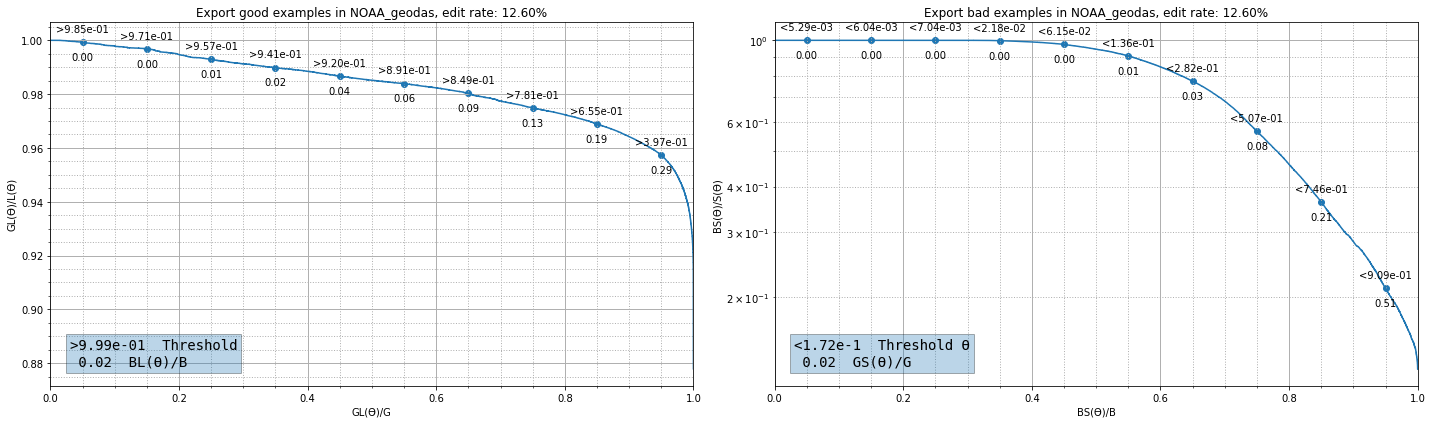

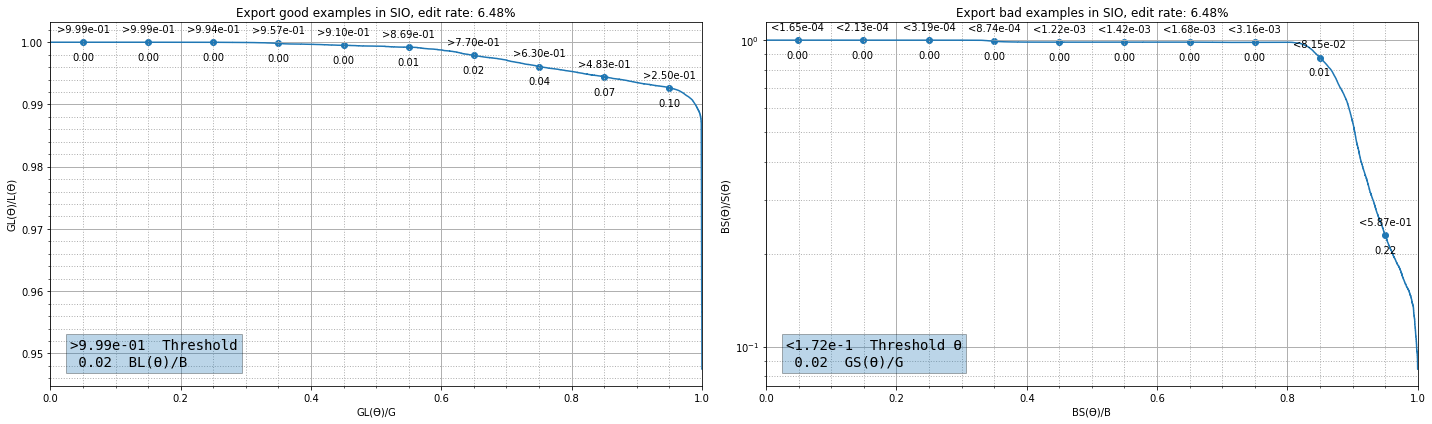

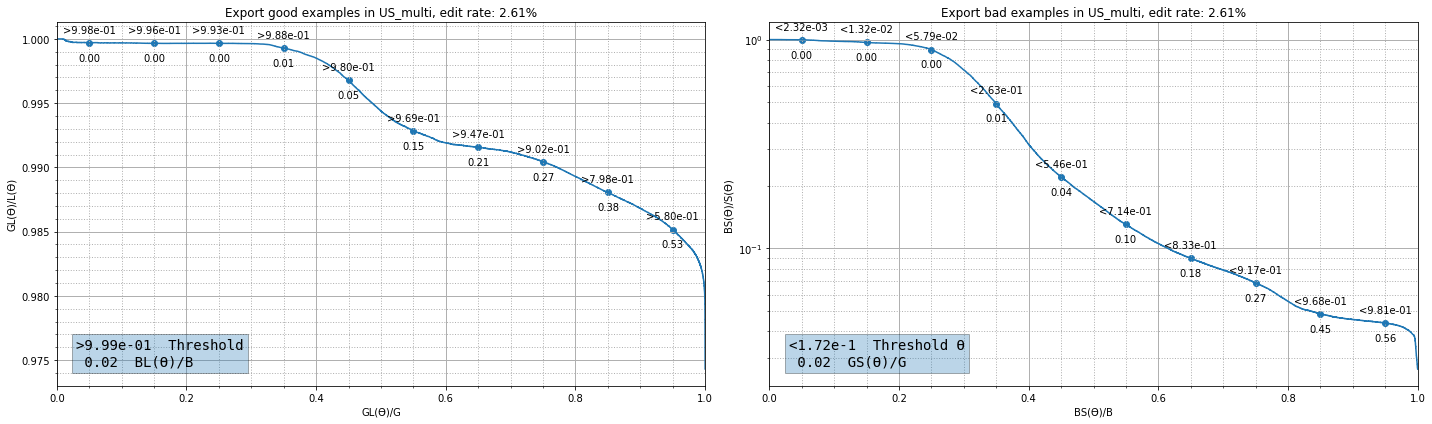

In [5]:
# Pre-chunks
for source in sources:
    print(source, end=", ")
    path = os.path.join(base_dir, "model_{0:}_test_{0:}_scores.pkl".format(source))
    with open(path, 'rb') as f:
        data = pickle.load(f)
    plot_edit_rescue(data, source)

# Scores CDF

In [ ]:
def get_margin_plot(scores0, weights0, scores1, weights1, labels, ax, legends=None, title=None, colors=['b', 'r']):
    y0 = np.cumsum(weights0) / np.sum(weights0)
    ax[0].plot(scores0, 1.0 - y0, colors[0], label=labels[0])
    ax[0].fill_between(scores0, 1.0 - y0, alpha=0.2, color=colors[0])
    y1 = np.cumsum(weights1) / np.sum(weights1)
    ax[0].plot(scores1, y1, colors[1], label=labels[1])
    ax[0].fill_between(scores1, y1, alpha=0.2, color=colors[1])
    ax[0].legend(loc=9)
    ax[0].set_xlabel('Margin Score')
    ax[0].set_ylabel('Weights %')
    if title:
        ax[0].set_title(title)

    y0 = np.cumsum(np.ones_like(weights0)) / weights0.shape[0]
    ax[1].plot(scores0, 1.0 - y0, colors[0], label=labels[0])
    ax[1].fill_between(scores0, 1.0 - y0, alpha=0.2, color=colors[0])
    y1 = np.cumsum(np.ones_like(weights1)) / weights1.shape[0]
    ax[1].plot(scores1, y1, colors[1], label=labels[1])
    ax[1].fill_between(scores1, y1, alpha=0.2, color=colors[1])
    ax[1].legend(loc=9)
    ax[1].set_xlabel('Margin Score')
    ax[1].set_ylabel('# Measures %')
    if title:
        ax[1].set_title(title)


def plot_scores(data, source):    
    _, labels, scores, weights = data
    scores0 = scores[labels == 0]
    weights0 = weights[labels == 0]
    order0 = np.argsort(scores0)
    scores0, weights0 = scores0[order0], weights0[order0]

    scores1 = scores[labels == 1]
    weights1 = weights[labels == 1]    
    order1 = np.argsort(scores1)
    scores1, weights1 = scores1[order1], weights1[order1]

    fig, ax = plt.subplots(1, 2, figsize=(20, 6))
    # for i in range(10):
    get_margin_plot(scores0, weights0, scores1, weights1,
                    ["good", "bad"], ax, colors=_style)

    for i in range(len(ax)):
        ax[i].grid(which='major', linestyle='-', linewidth='0.5', color='gray')
        ax[i].grid(which='minor', linestyle=':', linewidth='0.5', color='gray')

    ax[0].set_title('%s aggr. by weights\ndata_size=%d' % (source, labels.shape[0]))
    ax[1].set_title('%s aggr. by counts\ndata_size=%d' % (source, labels.shape[0]))

    # fig.savefig("filename.pdf", format="pdf")



Scores range	min 	max 
AGSO        	0.00	1.00
NGDC        	0.00	1.00
US_multi    	0.00	1.00
JAMSTEC     	0.00	1.00
NOAA_geodas 	0.00	1.00
NGA         	0.01	1.00
SIO         	0.00	1.00


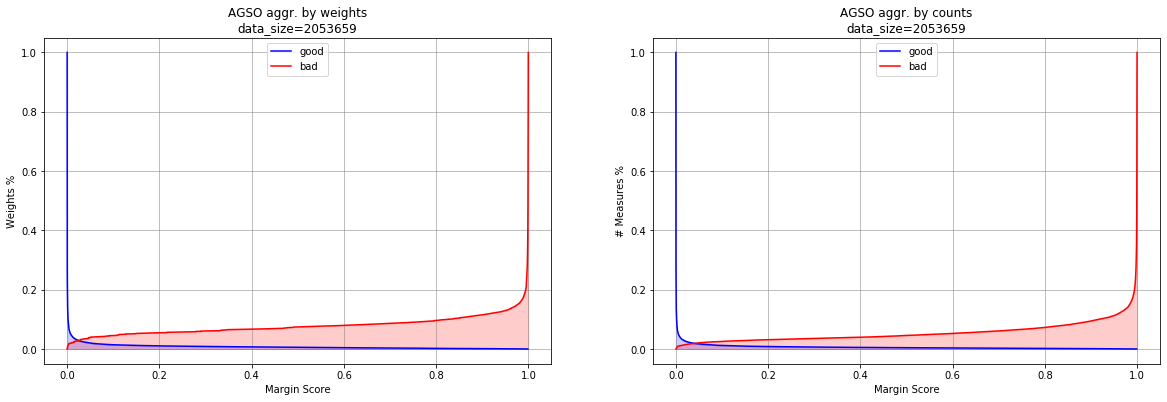

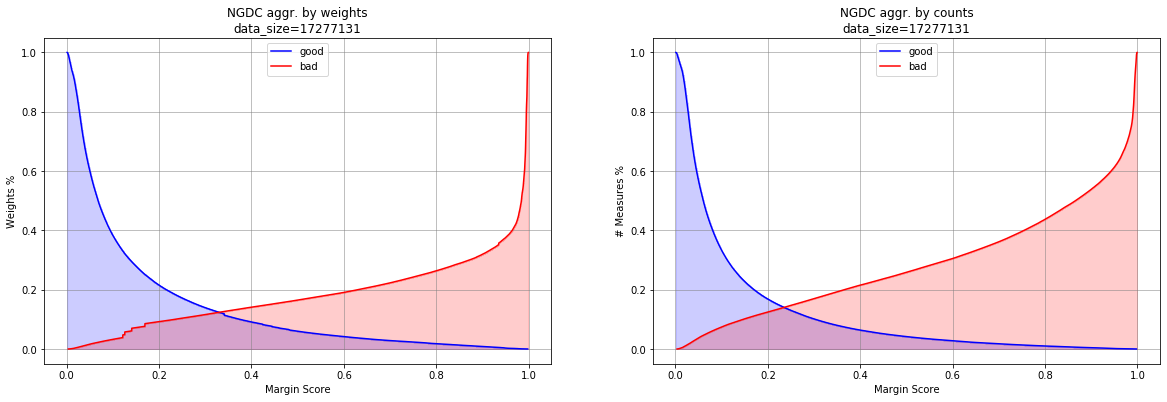

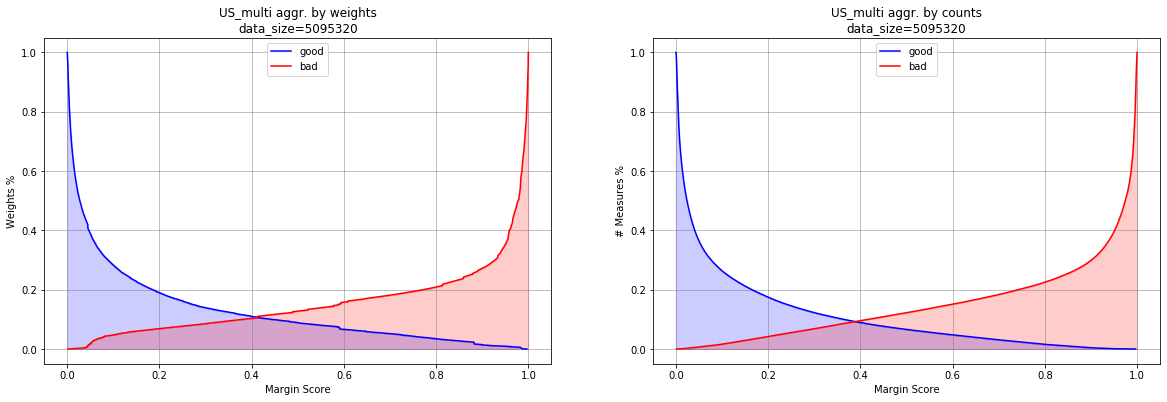

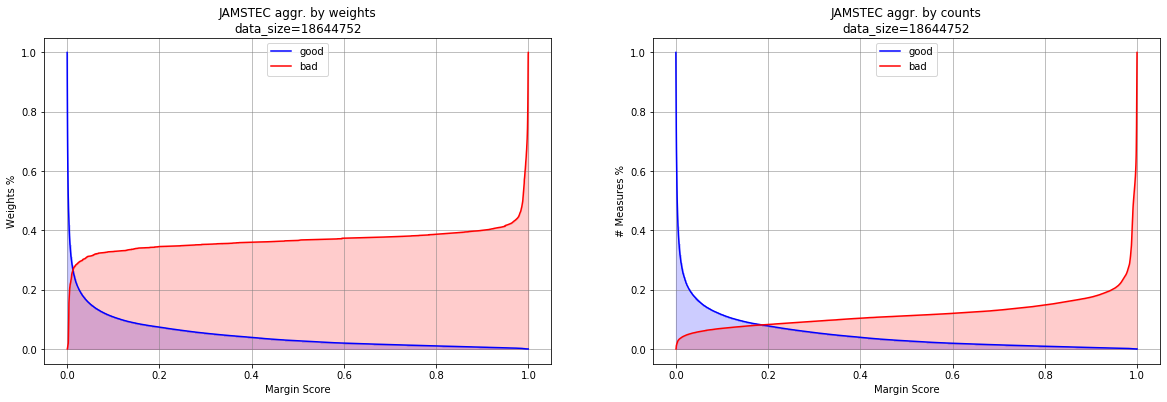

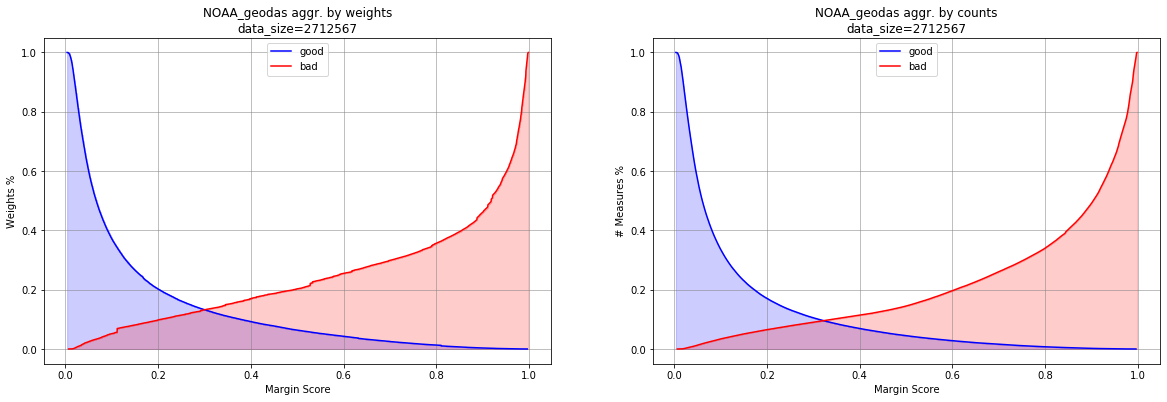

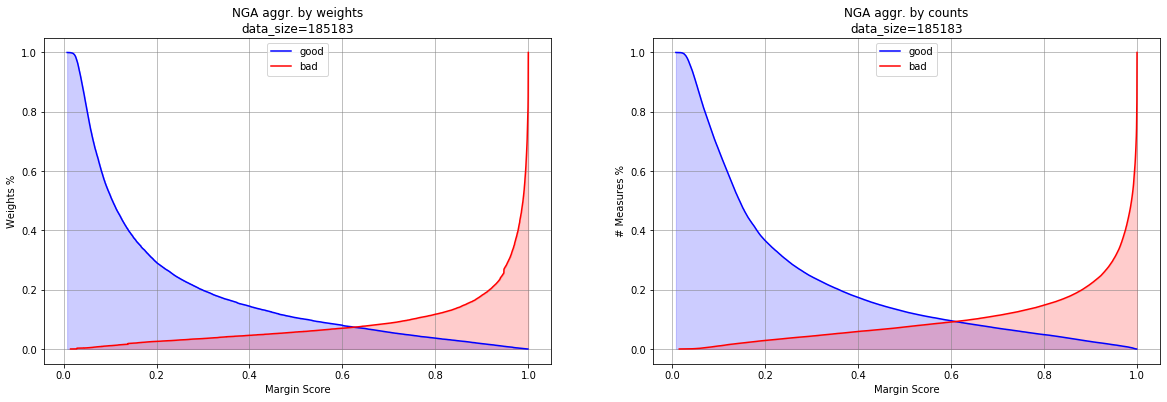

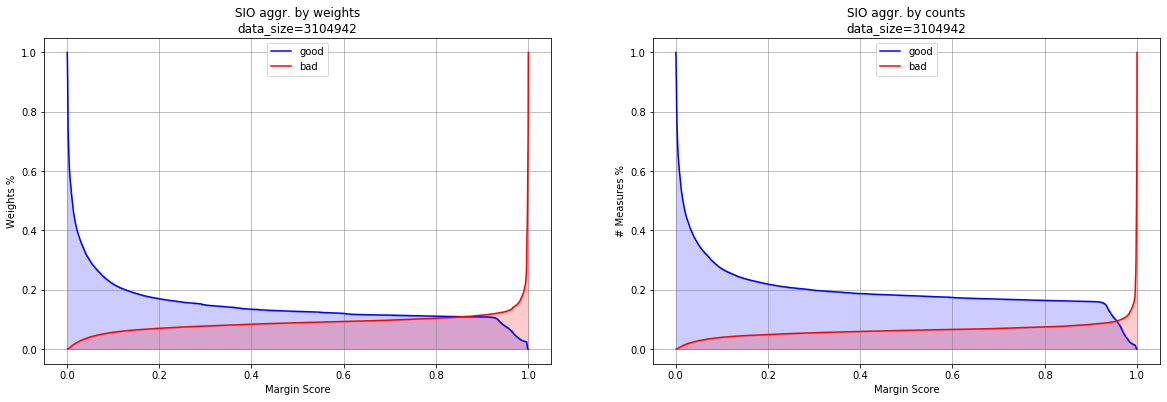

In [76]:
print("{0:12s}\t{1:4s}\t{2:4s}".format("Scores range", "min", "max"))
for source in sources:
    path = os.path.join(base_dir, "{}_scores.pkl".format(source))
    with open(path, 'rb') as f:
        data = pickle.load(f)
        _, _, scores, _ = data
        print("{0:12s}\t{1:.2f}\t{2:.2f}".format(source, np.min(scores), np.max(scores)))
        plot_scores(data, source)

Scores range	min 	max 
AGSO        	0.00	1.00
NGDC        	0.00	1.00
US_multi    	0.00	1.00
JAMSTEC     	0.00	1.00
NOAA_geodas 	0.00	1.00
NGA         	0.01	1.00
SIO         	0.00	1.00


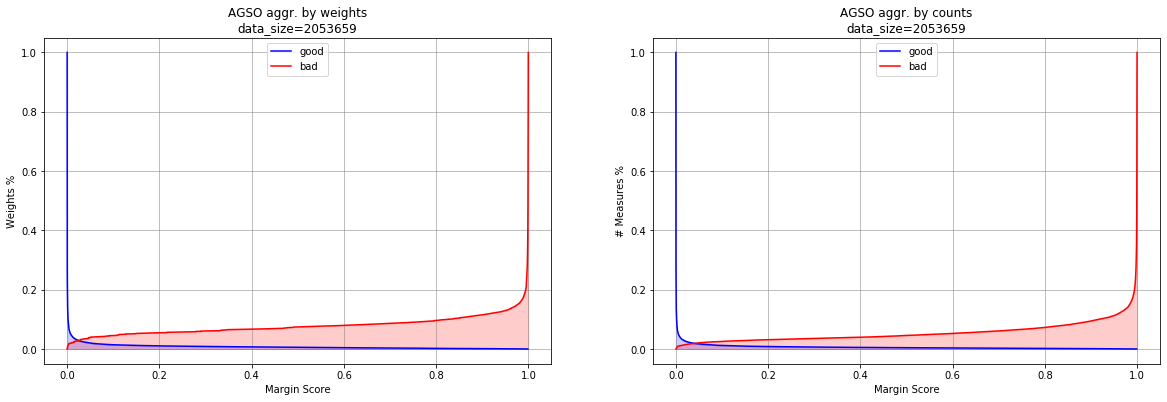

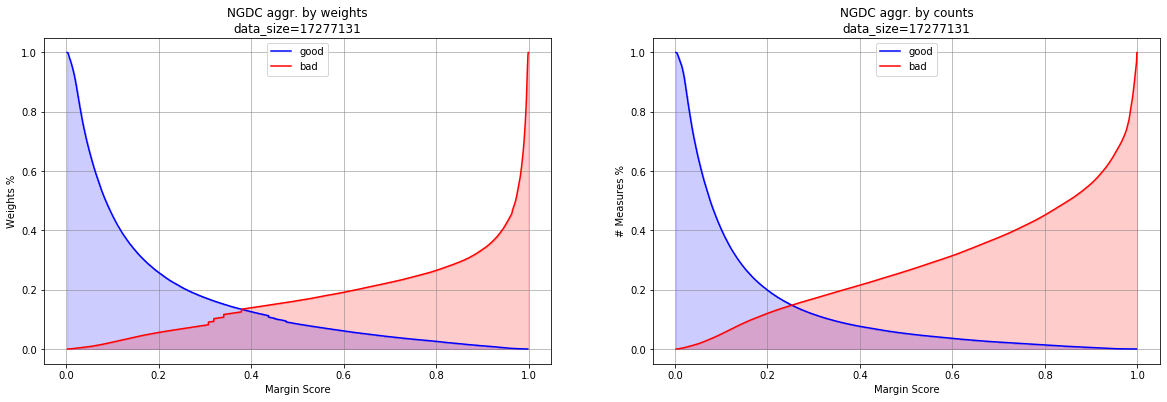

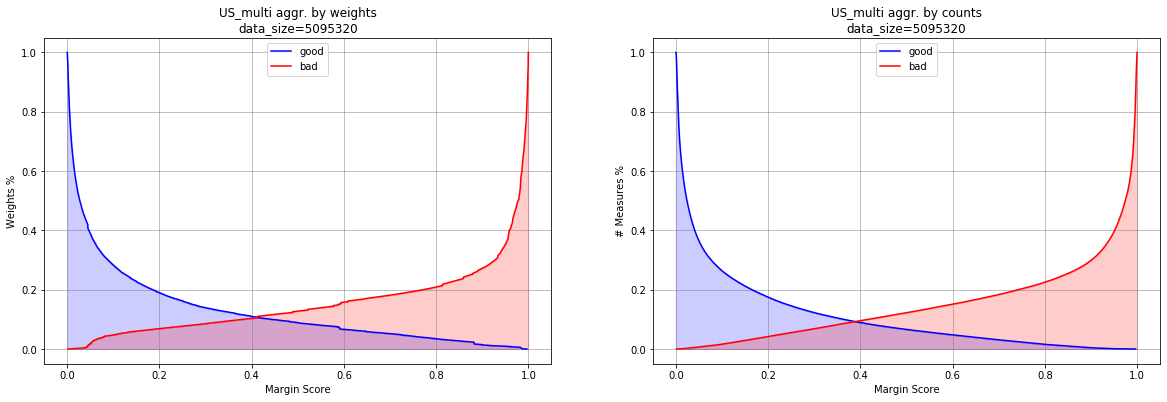

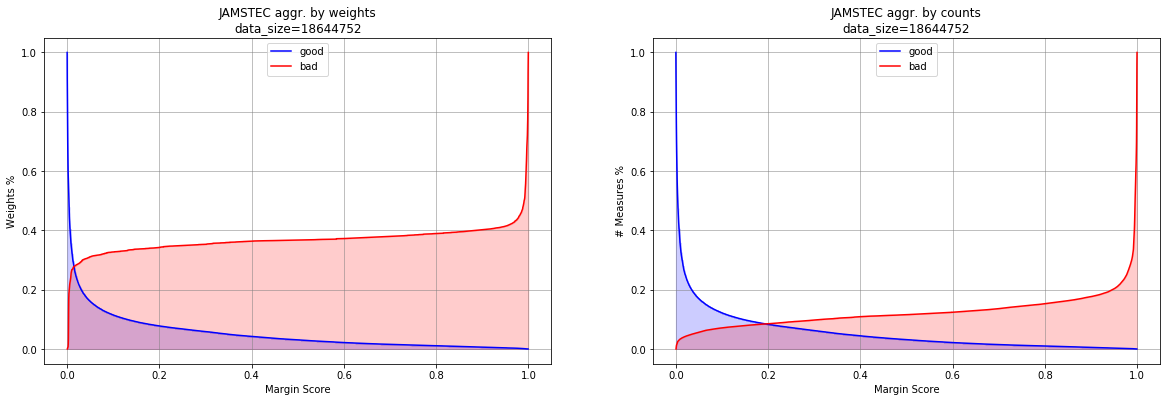

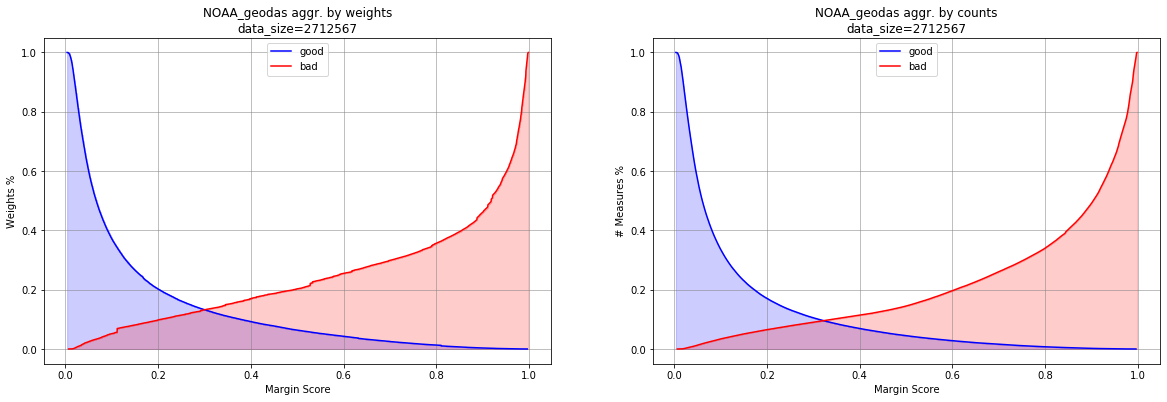

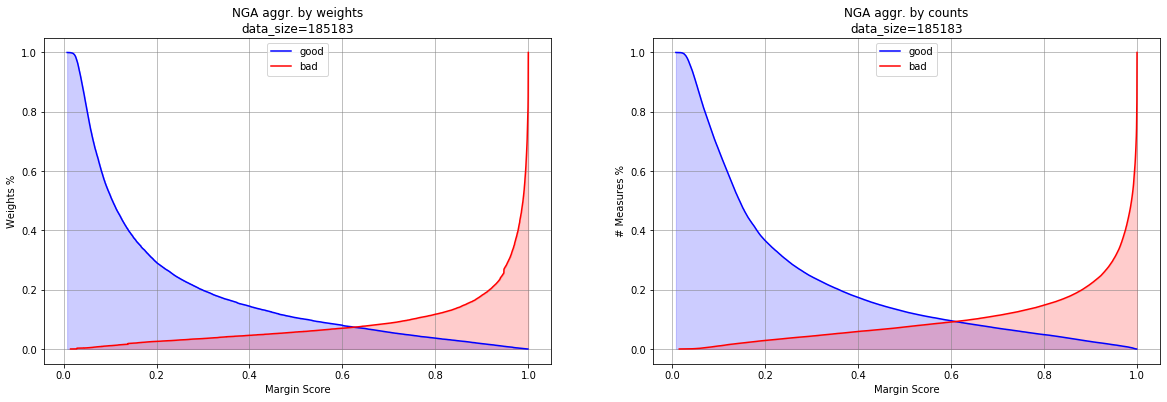

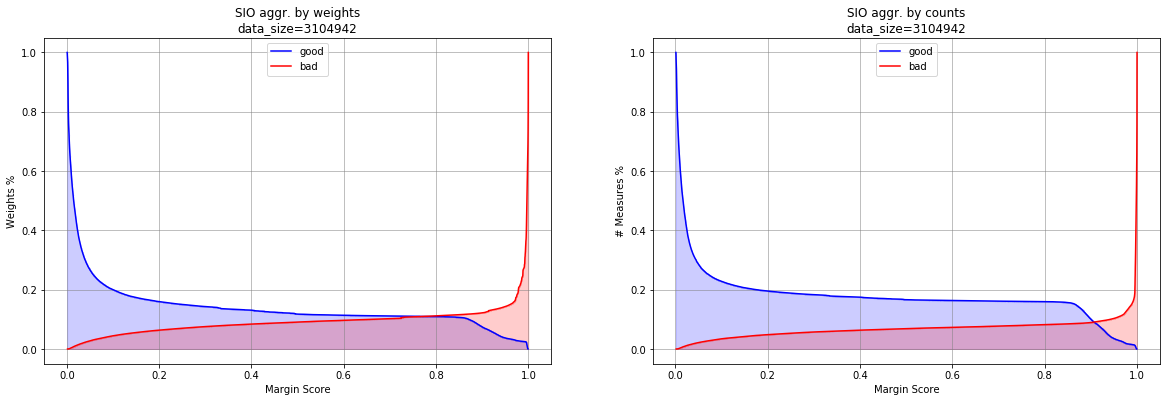

In [71]:
print("{0:12s}\t{1:4s}\t{2:4s}".format("Scores range", "min", "max"))
for source in sources:
    path = os.path.join(base_dir, "{}_scores.pkl".format(source))
    with open(path, 'rb') as f:
        data = pickle.load(f)
        _, _, scores, _ = data
        print("{0:12s}\t{1:.2f}\t{2:.2f}".format(source, np.min(scores), np.max(scores)))
        plot_scores(data, source)